# Time Series Analysis

Time series analysis can be used in a multitude of business applications for forecasting a quantity into the future and explaining its historical patterns. Here are just a few examples of possible use cases:

  - Explaining seasonal patterns in sales
  - Predicting the expected number of incoming or churning customers
  - Estimating the effect of a newly launched product on number of sold units

An ARIMA (AutoRegressive Integrated Moving Average) model is a class of statistical models for analyzing and forecasting time series data:

  - AR: Autoregression. A model that uses the dependent relationship between an observation and some number of **lagged observations** (p).

  - I: Integrated. The use of differencing (d) of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series **stationary**.

  - MA: Moving Average. A model that uses the dependency between an observation and a residual error from a **moving average** model (q) applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

  - **p**: The number of lag observations included in the model, also called the lag order.
  - **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
  - **q**: The size of the moving average window, also called the order of moving average.

If our model has a **seasonal component**, we use a seasonal ARIMA model (**SARIMA**). In that case we have another set of parameters: P,D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model. In particular, Statsmodel provides a Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model.

The process of fitting an ARIMA model is sometimes referred to as the **Box-Jenkins method**.


  1. **Examine your data**
   - Plot the data and examine its patterns and irregularities
   - Clean up any outliers or missing values if needed
   - Take a logarithm of a series to help stabilize a strong growth trend


  2. **Decompose your data**
   - Does the series appear to have trends or seasonality?
   - Use decompose() to examine and possibly remove components of the series
  
  
  3. **Stationarity**
   - Is the series stationary?
   -  Use ACF, PACF plots to determine order of differencing needed


  4. **Autocorrelations and choosing model order**
   - Choose order of the ARIMA by examining ACF and PACF plots


  5. **Fit a model (ARIMA and SARIMAX)**
   - Evaluate and iterate
   - Calculate forecast with SARIMAX

---



In [1]:
# Python set up
import warnings
import itertools
 
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot') 
import seaborn as sns  
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv(r"C:\Users\chira\OneDrive\Desktop\SEM 5\ATSA\Project\IPG2211A2N.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\chira\\OneDrive\\Desktop\\SEM 5\\ATSA\\Project\\IPG2211A2N.csv'

## Examine data

In [3]:
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4608
4,1939-05-01,3.4608


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1029 non-null   object 
 1   IPG2211A2N  1029 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


Convert index to time series

In [5]:
df.index = pd.to_datetime(df.DATE)
df = df.drop(['DATE'], axis=1)

In [6]:
df.index

DatetimeIndex(['1939-01-01', '1939-02-01', '1939-03-01', '1939-04-01',
               '1939-05-01', '1939-06-01', '1939-07-01', '1939-08-01',
               '1939-09-01', '1939-10-01',
               ...
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01'],
              dtype='datetime64[ns]', name='DATE', length=1029, freq=None)

Notice the dtype=’datetime64[ns]’ which confirms that it is a datetime object. 

In [7]:
# rename variable
df.columns = ['Production']

### Plot the data

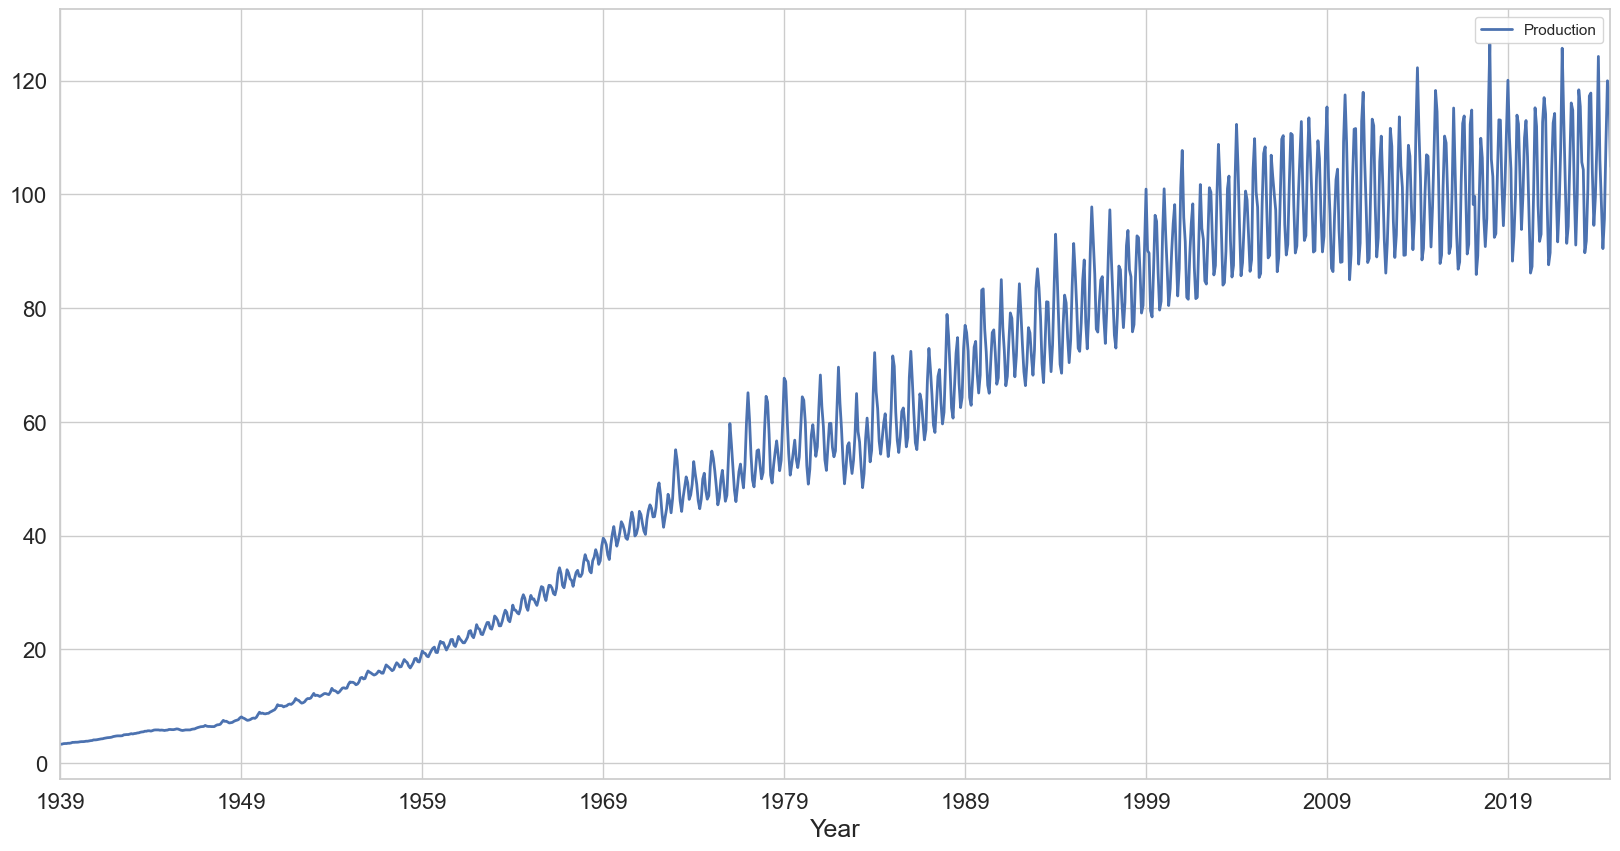

In [8]:
df.plot(figsize=(20,10), linewidth=2, fontsize=16)
plt.xlabel('Year', fontsize=18);

Here we can see there is an upward trend with regular (perhaps seasonally) fluctuations.

## Decompose data

The building blocks of a time series analysis are **seasonality**, **trend**, and **cycle**. These intuitive components capture the historical patterns in the series. Not every series will have all three (or any) of these components, but if they are present, deconstructing the series can help you understand its behavior and prepare a foundation for building a forecasting model.

  - Seasonal component refers to fluctuations in the data related to calendar cycles. For example, energy production might be lower in summer and during warm weather, and higher during colder months. Usually, seasonality is fixed at some number; for instance, quarter or month of the year.

  - Trend component is the overall pattern of the series: Is the production output increasing or decreasing over time?

  - Cycle component consists of decreasing or increasing patterns that are not seasonal. Usually, trend and cycle components are grouped together. Trend-cycle component is estimated using moving averages.

Finally, part of the series that can't be attributed to seasonal, cycle, or trend components is referred to as residual or error.

Formally, if Y is the production output, we can decompose the series in two ways: by using either an additive or multiplicative model:

An **additive model** is usually more appropriate when the seasonal or trend component is not proportional to the level of the series, as we can just overlay (i.e. add) components together to reconstruct the series. On the other hand, if the seasonality component changes with the level or trend of the series, a simple "overlay," or addition of components, won't be sufficient to reconstruct the series. In that case, a **multiplicative model** might be more appropriate.

As mentioned above, ARIMA models can be fitted to both seasonal and non-seasonal data. Seasonal ARIMA requires a more complicated specification of the model structure, although the process of determining (P, D, Q) is similar to that of choosing non-seasonal order parameters. Therefore, we will explore how to de-seasonalize the series and use a non-seasonal ARIMA model.

### Decompose with Statsmodels 

The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the trend, seasonal, and residual components of our data. You can actually access each component of the decomposition
(decomposition.trend, decomposition.seasonal, decomposition.residual) 

We can use an **additive model** when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 100 units of energy production). A **multiplicative model** is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of energy production everyyear).

Based off the previous chart, it looks like the trend in these earlier days is slightly increasing at a higher rate than just linear (although it is a bit hard to tell from this one plot, we can always experiment with additive versus multiplicative methods.).

---




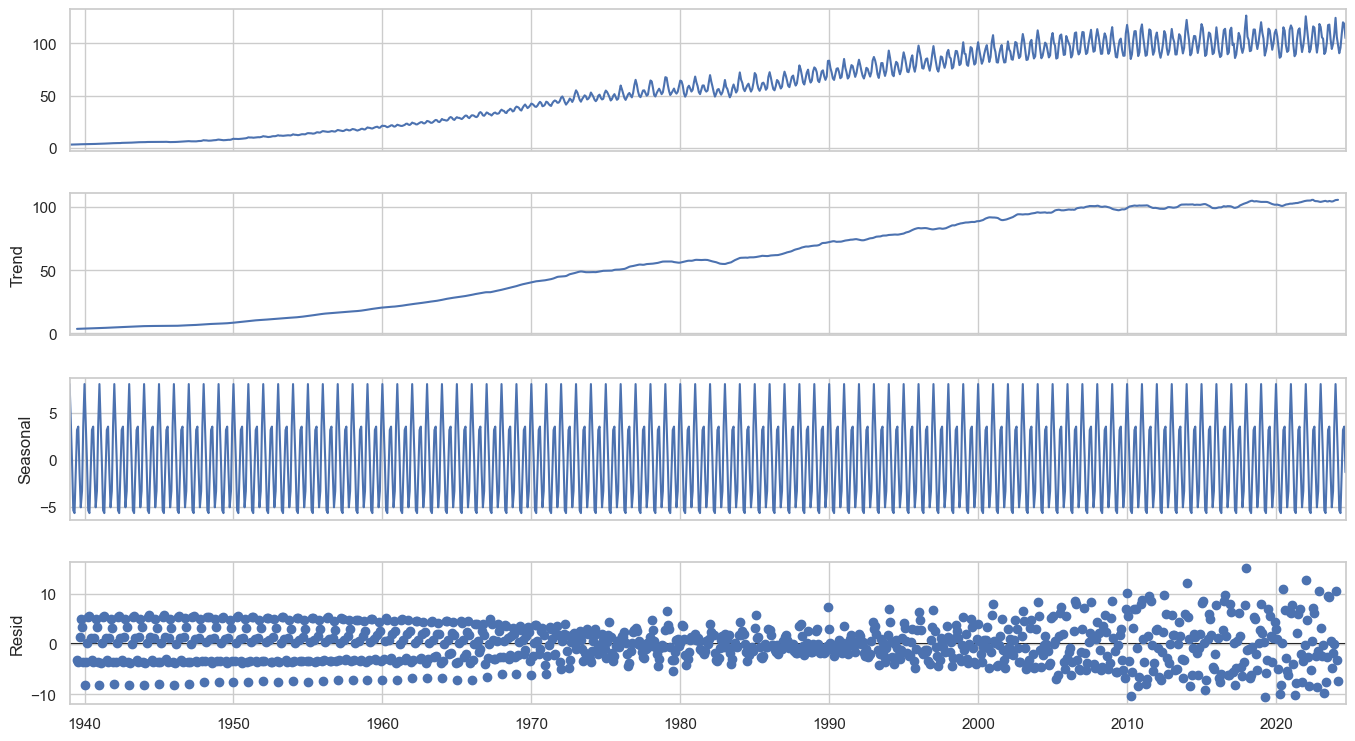

In [9]:
decomposition = seasonal_decompose(df, model='additive'); 
fig = decomposition.plot();
fig.set_size_inches(15, 8);

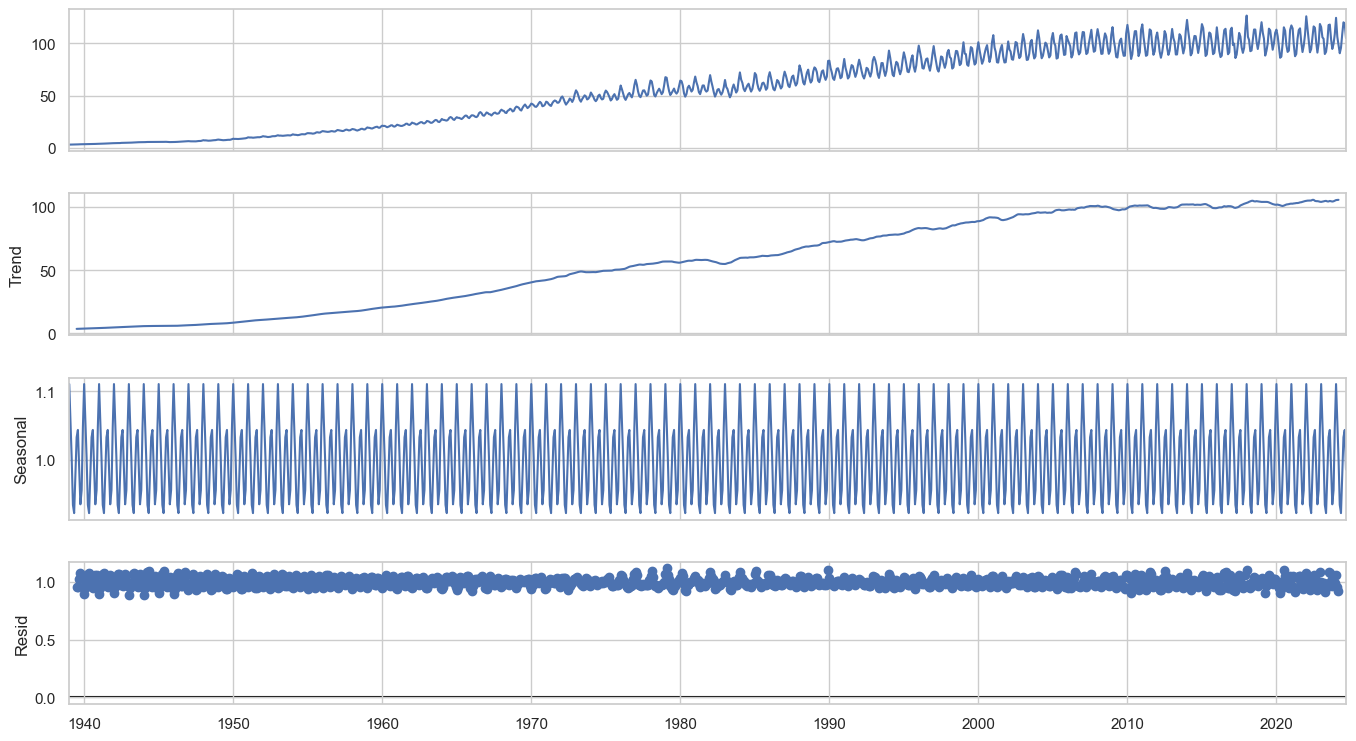

In [10]:
decomposition = seasonal_decompose(df, model='multiplicative')  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

From the plot above we can see the seasonal component of the data, and we can also see the separated upward trend of the data.

Trends can be upward or downward, and can be linear or non-linear. It is important to understand your data set to know whether or not a significant period of time has passed to identify an actual trend. Irregular fluctuations are abrupt changes that are random and unpredictable.

## Stationarity

Fitting an ARIMA model requires the series to be **stationary**. A series is said to be stationary when its mean, variance, and autocovariance are time invariant. Since ARIMA uses previous lags of series to model its behavior, modeling stable series with consistent properties involves less uncertainty. 

What exactly does it mean for data to be stationary?

1. The mean of the series should not be a function of time. 
2. The variance of the series should not be a function of time. This property is known as homoscedasticity. 
3. Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. 

Why is this important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

The **augmented Dickey-Fuller (ADF)** test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.


### Augmented Dickey-Fuller test

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. 

The null hypothesis of the test is that the time series can be represented by a unit root, that it is **not stationary** (has some time-dependent structure). 

The alternate hypothesis (rejecting the null hypothesis) is that the time series is **stationary**.

   - Null Hypothesis (H0): 

   - If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

   - Alternate Hypothesis (H1): 

   - The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

 - p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
 - p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

The statsmodels library provides the adfuller() function that implements the test.

  

In [11]:
#ADF Test
adfuller(df['Production'])

(-0.7362987721608432,
 0.8371220104401385,
 22,
 1006,
 {'1%': -3.436866962597422,
  '5%': -2.864417284603703,
  '10%': -2.5683020002450507},
 4346.189164201767)

In [12]:
# ADF Test with better readable output
result = adfuller(df['Production'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.7362987721608432
p-value: 0.8371220104401385
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


Running the example prints the test statistic value. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the significance of the ADF statistic.

The result suggests that we can't reject the null hypothesis. Not rejecting the null hypothesis means that the process has a *unit root*, and in turn that the time series is *non-stationary* (this means it does have a *time-dependent structure*).

### Differencing

Usually, non-stationary series can be corrected by a simple transformation such as differencing. Differencing the series can help in removing its trend or cycles. The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might. The difference is calculated by subtracting one period's values from the previous period's values. 

The number of differences performed is represented by the **d component of ARIMA**. Now, we move on to diagnostics that can help determine the order of differencing.

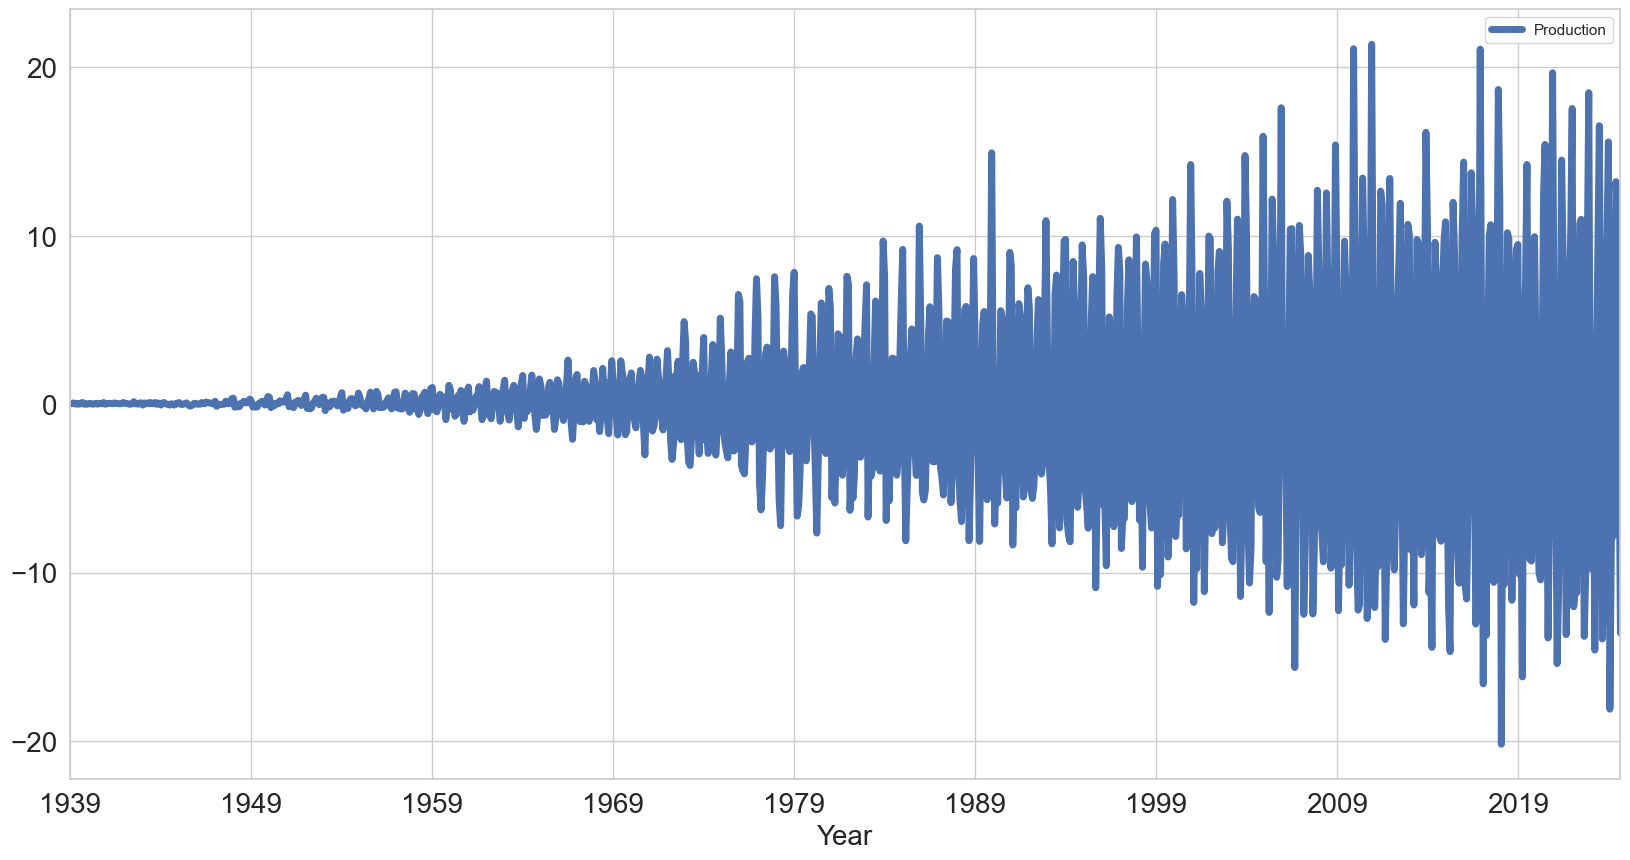

In [13]:
df.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

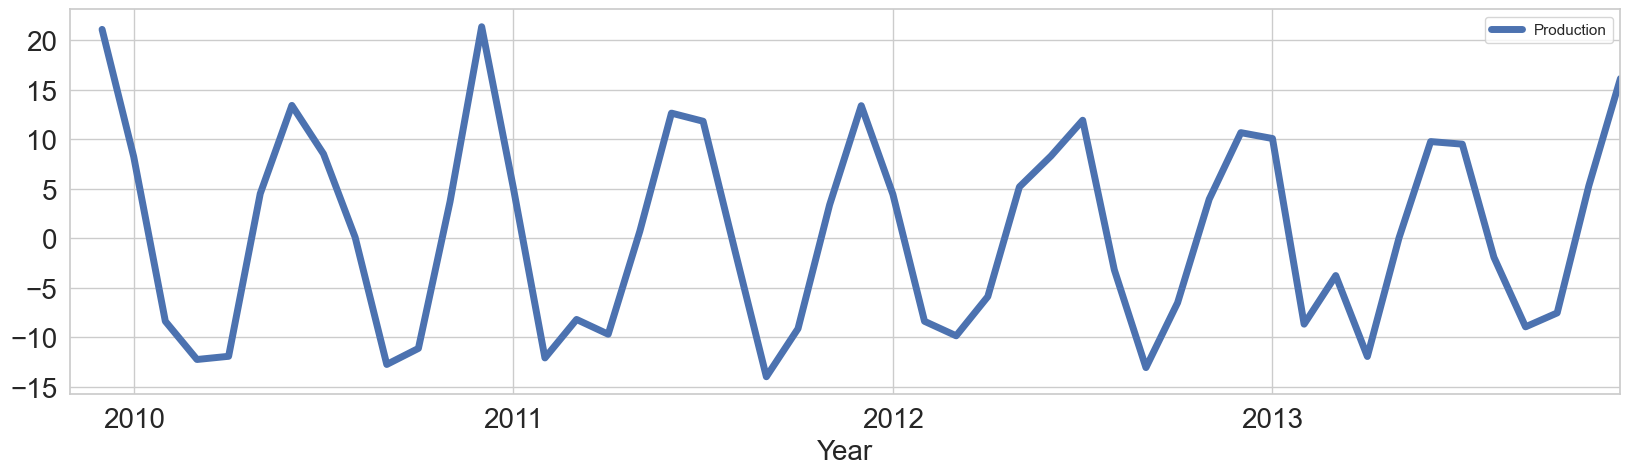

In [14]:
# reduce data to get a better picture of the distribution
df2 = df.iloc[850:900] 
df2.diff().plot(figsize=(20,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);


See that you have removed much of the trend and you can see the peaks in every year. 

Note: you can also perform 2nd order differencing, which means that you would be looking at the difference between one data point and the two that precede it, if the trend is not yet entirely removed. See here for more on differencing.

## Autocorrelations and Choosing Model Order

Autocorrelation plots (also known as **ACF** or the auto correlation function) are a useful visual tool in determining whether a series is stationary. These plots can also help to choose the **order parameters for ARIMA model**. If the series is correlated with its lags then, generally, there are some trend or seasonal components and therefore its statistical properties are not constant over time. If time series is random, such autocorrelations should be near zero for any and all time-lag separations.

ACF plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the **MA (q) model**. 

Partial autocorrelation plots (**PACF**), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the **AR(p)** model.



Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.

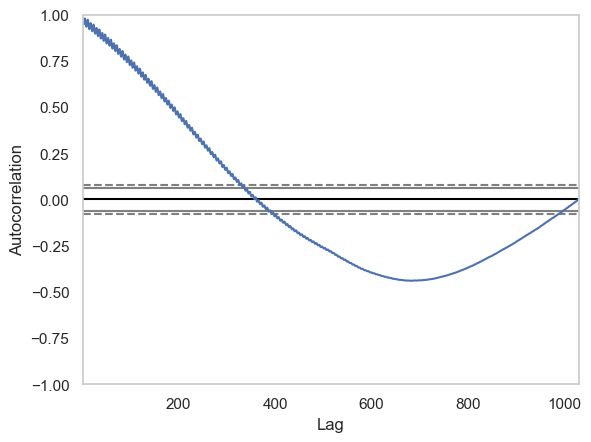

In [15]:
autocorrelation_plot(df);

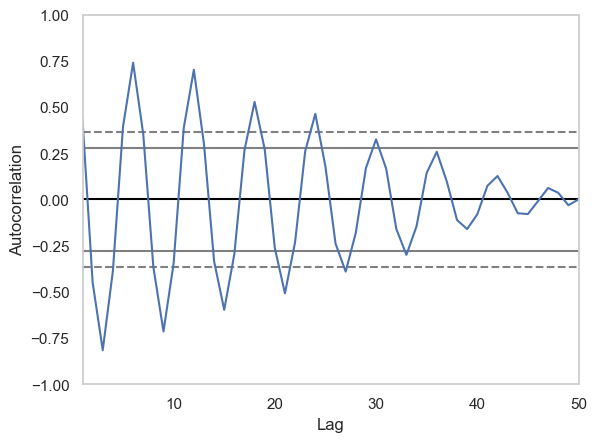

In [16]:
autocorrelation_plot(df2);

The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. 

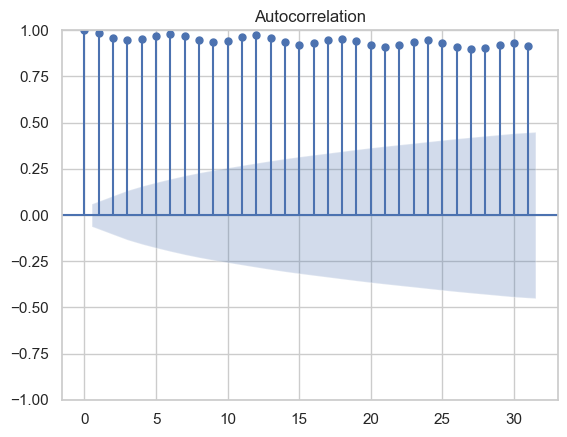

In [17]:
plot_acf(df);

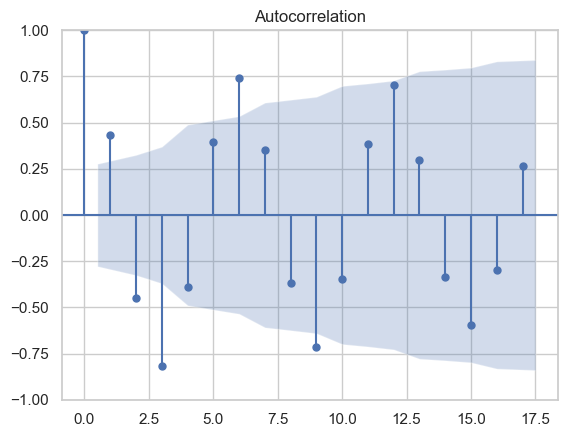

In [18]:
plot_acf(df2);

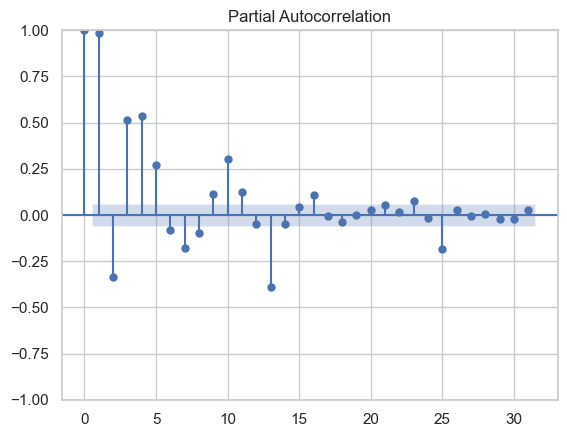

In [19]:
plot_pacf(df);

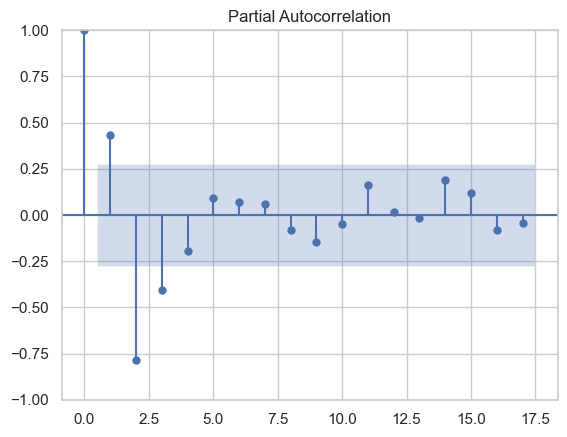

In [20]:
plot_pacf(df2);

## Fitting an model



### ARIMA

The statsmodels library provides the capability to fit an ARIMA model. An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters. The model is prepared on the training data by calling the fit() function. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the **lag value (p)** to 5 for autoregression, uses a **difference order d** of 1 to make the time series stationary, and uses a **moving average model q** of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

In [21]:
# fit model
# order (p, d, q)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(5,1,0))
results = model.fit()

c:\Users\chira\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\chira\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\chira\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [22]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                 1029
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2614.066
Date:                Sun, 10 Nov 2024   AIC                           5240.133
Time:                        10:54:38   BIC                           5269.745
Sample:                    01-01-1939   HQIC                          5251.372
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0709      0.021     -3.434      0.001      -0.111      -0.030
ar.L2         -0.4143      0.022    -18.896      0.000      -0.457      -0.371
ar.L3         -0.5569      0.021    -27.003      0.0

<Axes: xlabel='DATE'>

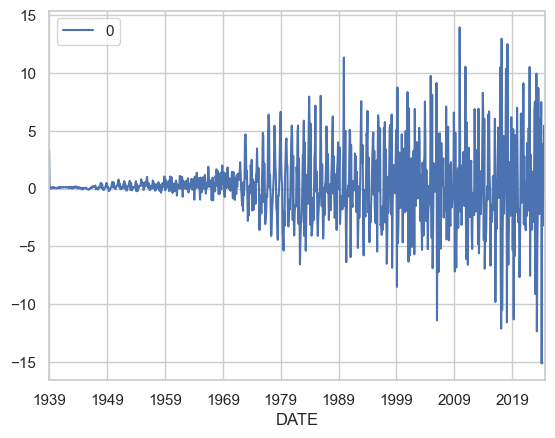

In [23]:
# plot residual errors
residuals = pd.DataFrame(results.resid)
residuals.plot()

First, we get a line plot of the residual errors, suggesting that there may still be trend information not captured by the model.

<Axes: ylabel='Density'>

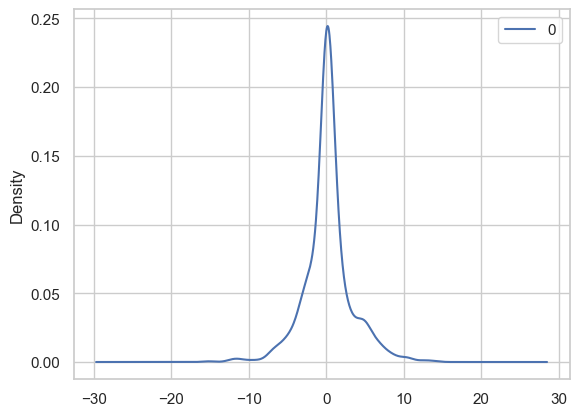

In [24]:
residuals.plot(kind='kde')

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian.

In [25]:
print(residuals.describe())

                 0
count  1029.000000
mean      0.255663
std       3.063120
min     -15.129297
25%      -0.818617
50%       0.126507
75%       1.152909
max      13.953684


Since we often have to cope with seasonality issues, we now take a closer look at seasonal ARIMA. Statsmodel provides a Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model. We will use the SARIMAX model to cover the issue of forecasting.

---


### SARIMAX-Model

When looking to fit time series data with a **seasonal** ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. We could use the above described procedere or resolve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.


### Grid search

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. 

Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let's begin by generating the various combination of parameters that we wish to assess.

In [26]:
# Define the p, d and q parameters 
# In our example, we only take values between 0 and 2 to make the computation faster
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In statistics and machine learning, this process is known as **grid search** (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the **AIC** (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. 

The **AIC** measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.



In [27]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = smf.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11571.701918784936
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10128.28268534174
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:5078.06892020815
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:5029.471552085336
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4975.704775011736
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4932.88972707058
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:5033.236112668469
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:5031.123919164266
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10225.460112217006
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8874.67548753751
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4757.115169048694
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4673.372563150096
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4705.909461736024
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4595.8074324828685
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4679.312331177793
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4672.968136918626
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:6530.743896913509
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5761.393287988394
ARIMA(0, 1

In [28]:
results.aic

4157.92502621529

Because some parameter combinations may lead to numerical misspecifications, we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we make sure to catch these exceptions and ignore the parameter combinations that cause these issues.

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value. We should therefore consider this to be optimal option out of all the models we have considered.

### Fitting the SARIMAX-Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model:

In [29]:
mod = smf.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4755      0.023     20.580      0.000       0.430       0.521
ma.L1         -0.9318      0.012    -76.505      0.000      -0.956      -0.908
ar.S.L12   -4.661e-06      0.025     -0.000      1.000      -0.049       0.049
ma.S.L12      -0.7339      0.023    -32.021      0.000      -0.779      -0.689
sigma2         3.6579      0.102     36.007      0.000       3.459       3.857


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. 

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

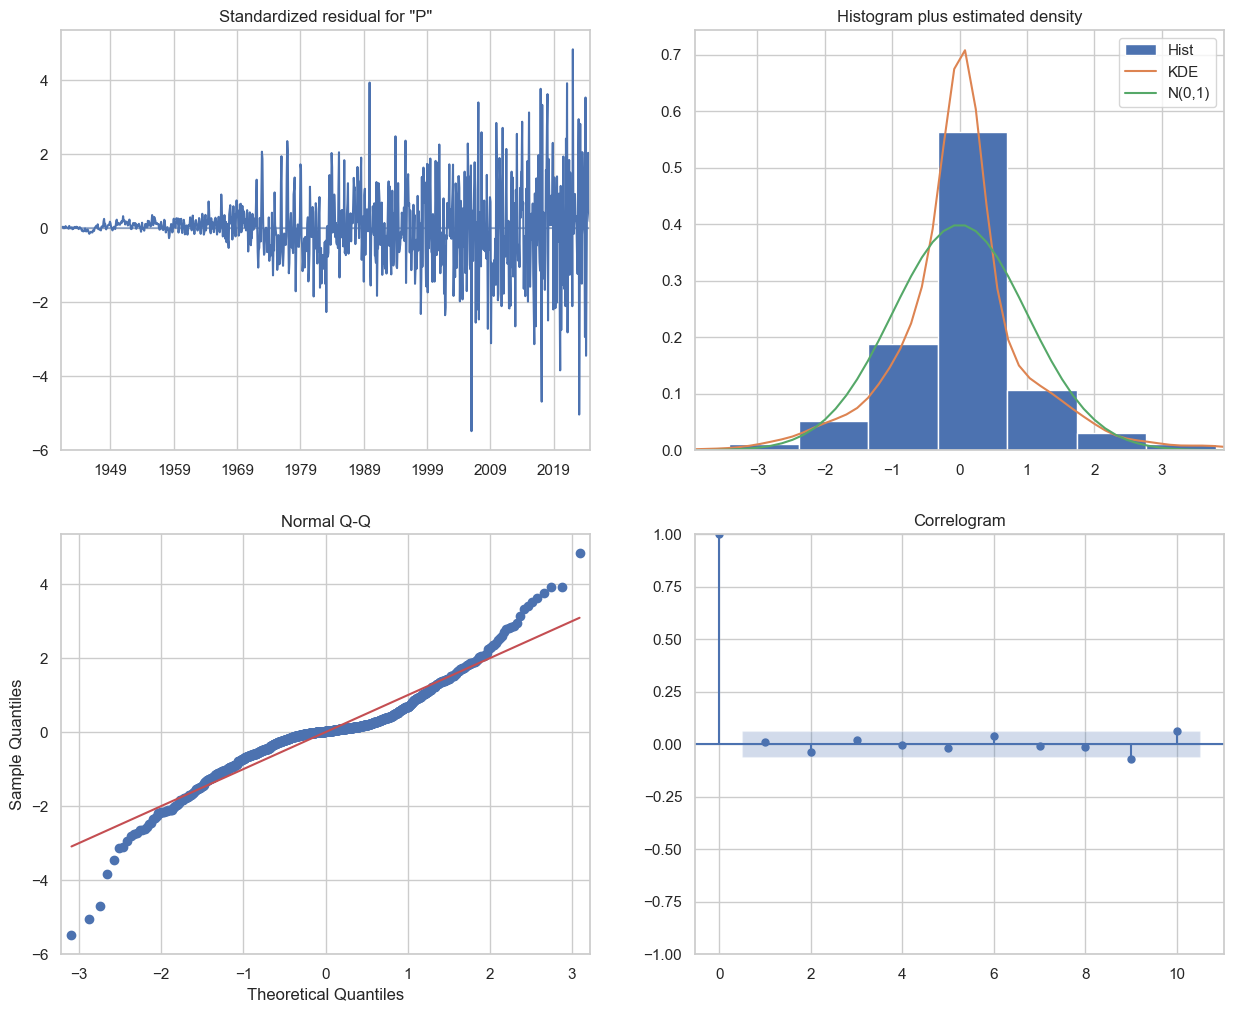

In [30]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved (which is the case in our example).

Our model diagnostics suggests that the model residuals are almost normally distributed based on the following:

In the top right plot, we see that the red KDE line almost follows with the N(0,1) line (where N(0,1))is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is an indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) do not optimally follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is an indication that the residuals are almost normally distributed.

However, the residuals over time (top left plot) display an obvious pappern and don't appear to be white noise. 

The autocorrelation (i.e. correlogram) plot on the bottom right shows that the time series residuals have very low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

###  Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The code above requires the forecasts to start at January 2017.

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the energy production time series to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.

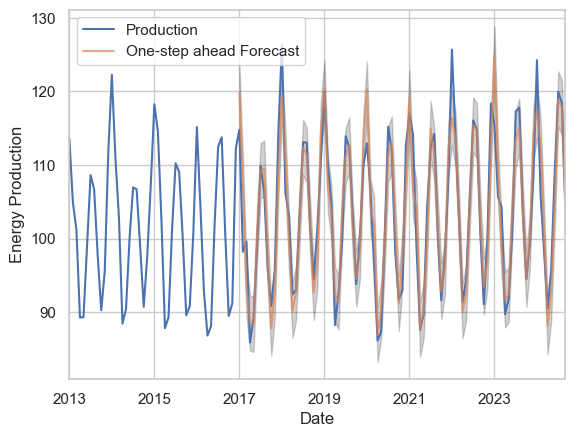

In [32]:
ax = df['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Energy Production')
plt.legend()

plt.show()

Overall, our forecasts align with the true values relatively well.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

### Model Accuracy: Mean squared error (MSE)

In [33]:
# Forecasts
df['y_forecasted'] = pred.predicted_mean
df['error_sq_2'] = (df['Production'] - pred.predicted_mean)**2
# Drop NAs and generate new DataFrame
df_pred = df.dropna()
# Sum of squared residuals (SS_R)
SS_R = df_pred['error_sq_2'].sum()
# calculate mean squared error of the model:
# Number of obeservations (lenght of DataFrame)
n = len(df_pred["error_sq_2"])
# calculate mse
mse = round((SS_R/(n-1)),2)
# print output
print('Mean squared error:', mse)

Mean squared error: 12.74


In [34]:
df_pred.head(5)

,Production,y_forecasted,error_sq_2
DATE,,,
2017-01-01,114.8134,119.816494,25.030947
2017-02-01,98.2094,107.175173,80.385084
2017-03-01,99.6332,93.254443,40.688543
2017-04-01,85.9072,88.523040,6.842618
2017-05-01,89.2037,88.361488,0.709321


---
---

In [35]:
df_pred.tail(5)

,Production,y_forecasted,error_sq_2
DATE,,,
2024-05-01,95.6705,92.654402,9.096848
2024-06-01,108.8832,104.984841,15.197201
2024-07-01,119.9540,118.965893,0.976356
2024-08-01,118.4844,117.819927,0.441524
2024-09-01,104.8967,104.541129,0.126431
